In [47]:
import torch
import slayerSNN as snn
from utils.helper import  *
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.manifold import TSNE

In [48]:
tauSr = 10
variant = 2
f_save = f'diagnostic_data/results/res_{tauSr}_{variant}'

In [49]:
# load the data
data = torch.load('diagnostic_data/train_test_data/all_var2.pt')
obj_list, iter_list, trial_list = pickle.load(open('diagnostic_data/train_test_data/info.pkl', 'rb'))
data.shape

torch.Size([160, 78, 2, 60])

In [50]:
# define network params
netParams = snn.params('network_config/network.yml')
netParams.parameters['neuron']['tauSr'] = tauSr
device = torch.device('cuda:02')
# Create snn loss instance.
error = snn.loss(netParams).to(device)

In [51]:
N,_,_,max_T = data.shape

tact_data_left = data[:,:39,...].to(device).unsqueeze(3).unsqueeze(3)
tact_data_right = data[:,39:,...].to(device).unsqueeze(3).unsqueeze(3)

In [52]:
def get_VR_distance():
    calculatedDistance_r = np.zeros([N,N])
    calculatedDistance_l = np.zeros([N,N])
    for i in range(N):
        for j in range(i, N):
            if i == j:
                dist_r=0.0
                dist_l=0.0
            else:
                dist_r = error.numSpikes(tact_data_right[i,...], tact_data_right[j,...]).item()
                dist_l = error.numSpikes(tact_data_left[i,...], tact_data_left[j,...]).item()
            calculatedDistance_r[i,j] = dist_r
            calculatedDistance_r[j,i] = dist_r
            calculatedDistance_l[i,j] = dist_l
            calculatedDistance_l[j,i] = dist_l
    return calculatedDistance_r, calculatedDistance_l

In [53]:
vr_r, vr_l  = get_VR_distance()

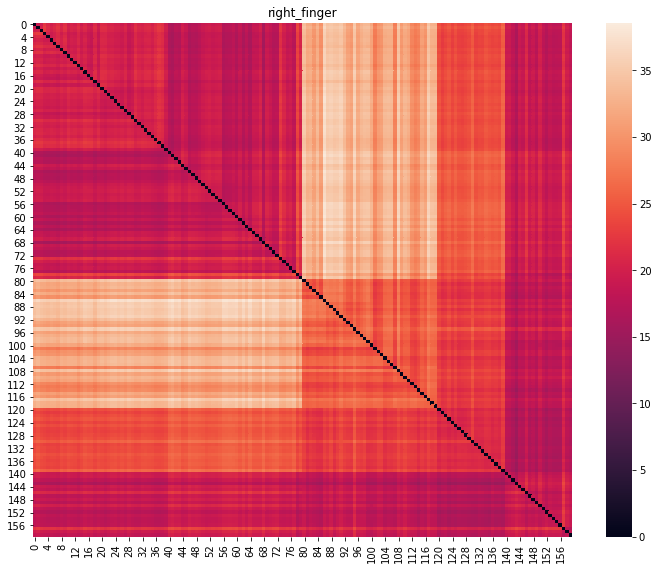

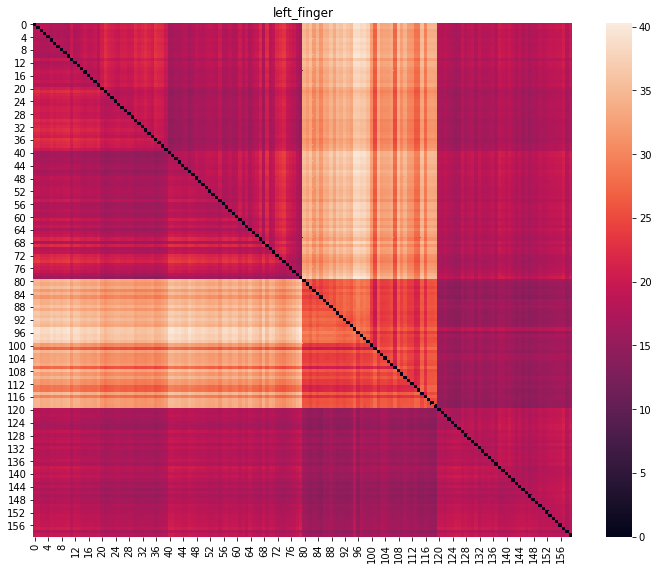

In [54]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(vr_r, annot=False, cbar=True)
plt.title('right_finger')
plt.tight_layout(True)
plt.savefig(f_save + '_heatmap_right.png' )
plt.show()

fig = plt.figure(figsize=(10,8))
sns.heatmap(vr_l, annot=False, cbar=True)
plt.title('left_finger')
plt.tight_layout(True)
plt.savefig(f_save + '_heatmap_left.png' )
plt.show()

In [55]:
perplexity = 10
t_sne = TSNE(n_components=2, metric='precomputed', perplexity=perplexity, random_state=0).fit_transform(vr_r)

In [56]:
tsne_df = pd.DataFrame(t_sne, columns=['x', 'y'])
tsne_df = tsne_df.assign(objs = obj_list)
tsne_df = tsne_df.assign(trials = trial_list)

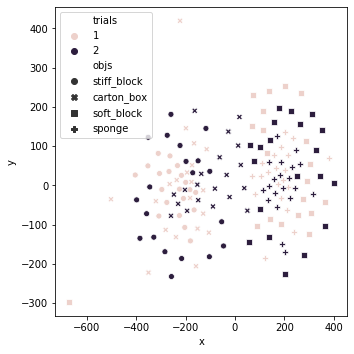

In [57]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(
    x='x', y='y',
    style="objs",
    hue='trials',
    data =tsne_df,
    legend="full",
    ax=ax,
)
plt.tight_layout(True)
plt.savefig(f_save + '_tsne_right_' + str(perplexity) + '.png')
plt.show()

In [58]:
perplexity = 25

In [59]:
t_sne = TSNE(n_components=2, metric='precomputed', perplexity=perplexity, random_state=0).fit_transform(vr_l)
tsne_df = pd.DataFrame(t_sne, columns=['x', 'y'])
tsne_df = tsne_df.assign(objs = obj_list)
tsne_df = tsne_df.assign(trials = trial_list)

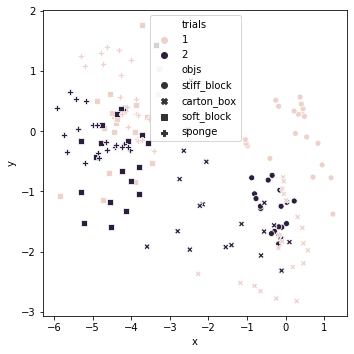

In [60]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(
    x='x', y='y',
    style="objs",
    hue='trials',
    data =tsne_df,
    legend="full",
    ax=ax,
)
plt.tight_layout(True)
plt.savefig(f_save + '_tsne_left_' + str(perplexity) + '.png')
plt.show()